# MNIST Digits Classification

In [6]:
# get the data

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X,y = mnist["data"].values, mnist["target"]

In [8]:
X.shape

(70000, 784)

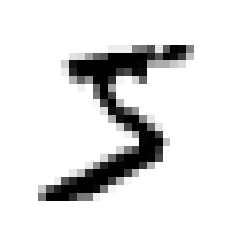

In [10]:
# plot images

import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [11]:
import numpy as np
y = y.astype(np.uint8)

In [12]:
# Split to train and test

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Make y binary

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### Sgd classifier

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
#cross validation code

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone #deep copy creator

skfolds = StratifiedKFold(n_splits =3, random_state = 42, shuffle = True)

# loop over folds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #deep copy
    X_train_folds = X_train[train_index] # subset train
    y_train_folds = y_train_5[train_index] #subset y train
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.9669
0.91625
0.96785


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,
scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [19]:
# cross validation predict

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


# confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)


In [20]:
import pandas as pd
pd.DataFrame(cm, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])

,Predicted_0,Predicted_1
Actual_0,53892,687
Actual_1,1891,3530


In [21]:
# choosing threshold 
# get prob of each
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")


from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,
y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

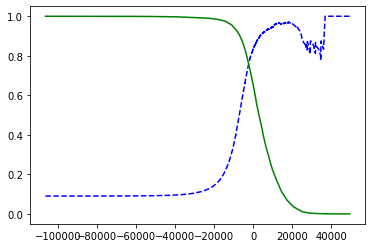

In [22]:
# recall can only go down when threshold is increased
# precision generally goes up but may go down
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# compute tpr and fpr for various thresholds

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

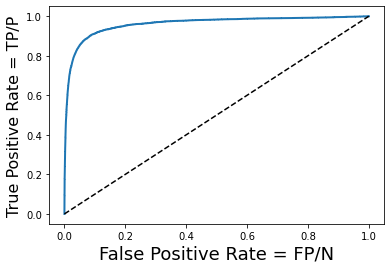

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate = FP/N', fontsize=18)
    plt.ylabel('True Positive Rate = TP/P', fontsize=16)# Dashed diagonal
plot_roc_curve(fpr, tpr)
plt.show()


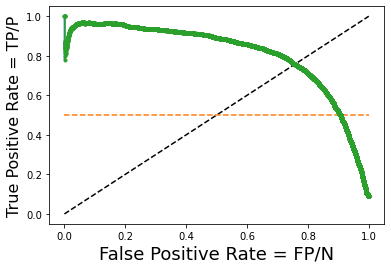

In [32]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)
auc_score = plot_roc_curve(recall, precision)

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()

# Multi-Class

In [35]:
from sklearn.svm import SVC
svm_clf = SVC()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale the scores
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


#cv predict - each row is repeated 3 times

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

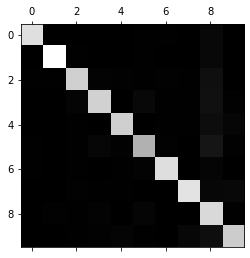

In [36]:
#plot confusion matrix

plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()


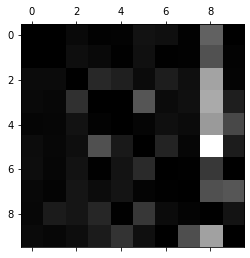

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonal with 0s so that we can focus on the errors 

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
